In [1]:
import warnings

import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')


In [2]:
PALLETTE = {
    'blue': '#064473',
    'orange': '#D95F02',
    'green': '#009E73',
    'red': '#C00000',
    'purple': '#E69F00',
    'brown': '#A6761D',
    'pink': '#F0E442',
    'grey': '#999999'
}

In [3]:
df_customer_value_dataset = pd.read_csv('../data/customer_value_dataset.csv')

In [4]:
df_customer_value_dataset.head()

,customer_id,analysis_date,recency,purchase_frequency_1_yr,purchase_amount_1_yr,tenure,total_purchase_amount,returns_frequency_1_yr,returned_amount_1_yr,purchase_amount_next_1_yr
0,1,2021-01-01,253,1,349.55226,2189,1616.49852,0,0.0,464.269813
1,1,2021-02-01,284,1,349.55226,2220,1616.49852,0,0.0,464.269813
2,1,2021-03-01,312,1,349.55226,2248,1616.49852,0,0.0,1101.848147
3,1,2021-04-01,343,1,349.55226,2279,1616.49852,0,0.0,1101.848147
4,1,2021-05-01,373,0,0.00000,2309,1616.49852,0,0.0,1101.848147


In [5]:
df_customer_value_dataset.analysis_date.unique()

array(['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
       '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
       '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
       '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
       '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
       '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
       '2023-01-01'], dtype=object)

### 1. Filter the dataset to focus on a single analysis date

In [6]:
train_data = df_customer_value_dataset[df_customer_value_dataset['analysis_date'] == '2021-01-01'].copy()

test_data = df_customer_value_dataset[df_customer_value_dataset['analysis_date'] == '2022-01-01'].copy()

X_train = train_data.drop(columns=['purchase_amount_next_1_yr', 'customer_id', 'analysis_date'])

y_train = train_data['purchase_amount_next_1_yr']

X_test = test_data.drop(columns=['purchase_amount_next_1_yr', 'customer_id', 'analysis_date'])

y_test = test_data['purchase_amount_next_1_yr']

### 2. Fit a number of regression models

In [7]:
# Initialize a linear regression model
lin_reg = LinearRegression()

# Initialize a penalized linear regression model with L2 regularization (default)
ridge_reg = Ridge(alpha=0.5)

# Initialize the Gradient Boosting Regressor
xgb_reg = GradientBoostingRegressor(random_state=42)

# Initialize the Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42)

# Initialize the knn regressor
knn_reg = KNeighborsRegressor()

models = [{'name': 'Linear Regression', 'model': lin_reg},
          {'name': 'Penalized Linear Regression (L2)', 'model': ridge_reg},
          {'name': 'Gradient Boosting Regressor', 'model': xgb_reg},
          {'name': 'Random Forest Regressor',  'model': rf_reg},
          {'name': 'K Nearest Neighbors Regressor',  'model': knn_reg}]

In [8]:
metrics = []

for model in models:

    # fit the model to the train data
    model['model'].fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = model['model'].predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    metrics.append({'name': model['name'],
                    'rmse': rmse})
    
pd.DataFrame(metrics).sort_values(by='rmse', ascending=True)

,name,rmse
1,Penalized Linear Regression (L2),308.766569
0,Linear Regression,308.766594
2,Gradient Boosting Regressor,311.282852
3,Random Forest Regressor,331.049470
4,K Nearest Neighbors Regressor,343.955185


### 3. Choose the best model and perform hyperparameter tuning

In [9]:
alphas = [x/10 for x in range(1, 11)]

hyperparameters_tuning_metrics = []

for alpha_param in alphas:
    # Initialize a penalized linear regression model with L2 regularization (default)
    ridge_reg = Ridge(alpha=alpha_param)

    # fit the model to the train data
    ridge_reg.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = ridge_reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    hyperparameters_tuning_metrics.append({'name': f'Penalized Linear Regression (L2) alpha={alpha_param}',
                                           'rmse': rmse})

In [10]:
pd.DataFrame(hyperparameters_tuning_metrics).sort_values(by='rmse', ascending=True) 

,name,rmse
9,Penalized Linear Regression (L2) alpha=1.0,308.766544
8,Penalized Linear Regression (L2) alpha=0.9,308.766549
7,Penalized Linear Regression (L2) alpha=0.8,308.766554
6,Penalized Linear Regression (L2) alpha=0.7,308.766559
5,Penalized Linear Regression (L2) alpha=0.6,308.766564
4,Penalized Linear Regression (L2) alpha=0.5,308.766569
3,Penalized Linear Regression (L2) alpha=0.4,308.766574
2,Penalized Linear Regression (L2) alpha=0.3,308.766579
1,Penalized Linear Regression (L2) alpha=0.2,308.766584
0,Penalized Linear Regression (L2) alpha=0.1,308.766589


### 4. Perform time series cross validation for all the available dates range

In [11]:
# helper function to obtain the indices of the train and test data
def generate_indices_by_date(df, start_date):
    current_train_date = pd.to_datetime(start_date)
    current_test_date = pd.to_datetime(start_date) + DateOffset(months=12)
    while True:
        next_train_date = current_train_date + DateOffset(months=1)
        next_test_date = current_train_date + DateOffset(months=13)
        indices_train_current = df[df['analysis_date'] == current_train_date.strftime('%Y-%m-%d')].index
        indices_test_current = df[df['analysis_date'] == current_test_date.strftime('%Y-%m-%d')].index
        
        if not indices_train_current.empty and not indices_test_current.empty:
            yield (current_train_date, current_test_date, indices_train_current, indices_test_current)
        else:
            return
        current_train_date = next_train_date
        current_test_date = next_test_date

In [12]:
# intiailize the generator
generator = generate_indices_by_date(df_customer_value_dataset, '2021-01-01')

In [13]:
best_alpha = 1.0

time_series_cv_metrics = []

for data in generator:

    train_date = data[0]
    test_date = data[1]

    train_data = df_customer_value_dataset.iloc[data[2]]

    X_train = train_data.drop(columns=['purchase_amount_next_1_yr', 'customer_id', 'analysis_date'])
    y_train = train_data['purchase_amount_next_1_yr']

    #test_date = df_customer_value_dataset.iloc[data[1]]

    test_data = df_customer_value_dataset.iloc[data[3]]

    X_test = test_data.drop(columns=['purchase_amount_next_1_yr', 'customer_id', 'analysis_date'])
    y_test = test_data['purchase_amount_next_1_yr']

    # Initialize and train the model
    ridge_reg = Ridge(alpha=best_alpha)

    ridge_reg.fit(X_train, y_train)

    # Make predictions
    y_pred = ridge_reg.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    time_series_cv_metrics.append({'test_date': test_date,
                                   'rmse': rmse})
    
df_time_series_cv_metrics = pd.DataFrame(time_series_cv_metrics)
    

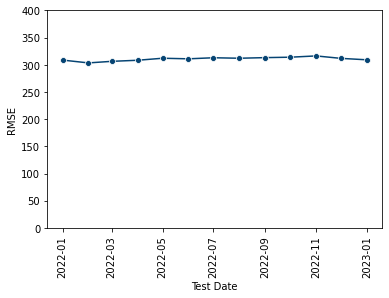

In [14]:
sns.lineplot(data=df_time_series_cv_metrics, x='test_date', y='rmse', marker='o', color=PALLETTE['blue'])
plt.xticks(rotation=90)
plt.ylim(0, 400)
plt.ylabel('RMSE')
plt.xlabel('Test Date')
plt.show()

### 5. Perform visual validation of the predictions

In [15]:
inference_data = df_customer_value_dataset[df_customer_value_dataset['analysis_date'] == '2023-01-01'].copy()

X_validation = inference_data.drop(columns=['purchase_amount_next_1_yr', 'customer_id', 'analysis_date'])
y_validation = inference_data['purchase_amount_next_1_yr']

y_pred_validation = ridge_reg.predict(X_validation)

inference_data['prediction'] = y_pred_validation

### 5.1. Validate predictions by recency class

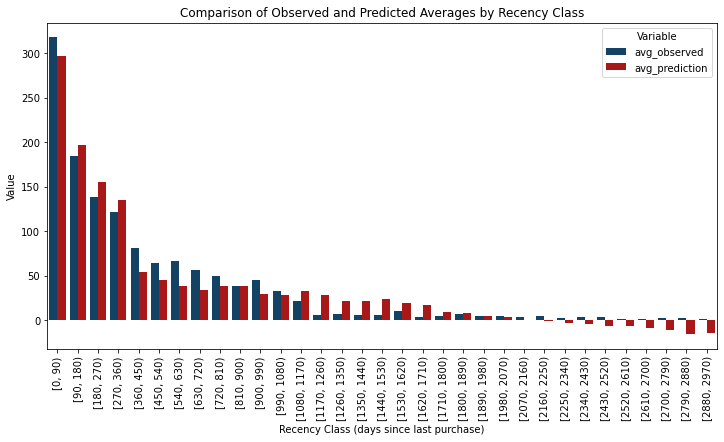

In [16]:
df_recency = inference_data.copy()

df_recency['recency_class'] = pd.cut(df_recency['recency'], bins=range(0, df_recency['recency'].max() + 90, 90), right=False)

df_recency_grouped = df_recency.groupby('recency_class').\
    agg(avg_observed = ('purchase_amount_next_1_yr','mean'),
        avg_prediction = ('prediction', 'mean')).\
        reset_index().\
        melt(id_vars='recency_class')

# Create a seaborn bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_recency_grouped, x='recency_class', y='value', hue='variable', palette=[PALLETTE['blue'], PALLETTE['red']])

# Add labels and title
plt.xlabel('Recency Class (days since last purchase)')
plt.xticks(rotation=90)
plt.ylabel('Value')
plt.title('Comparison of Observed and Predicted Averages by Recency Class')
plt.legend(title='Variable')

# Show the plot
plt.show()


### 5.2. Validate predictions by frequency class

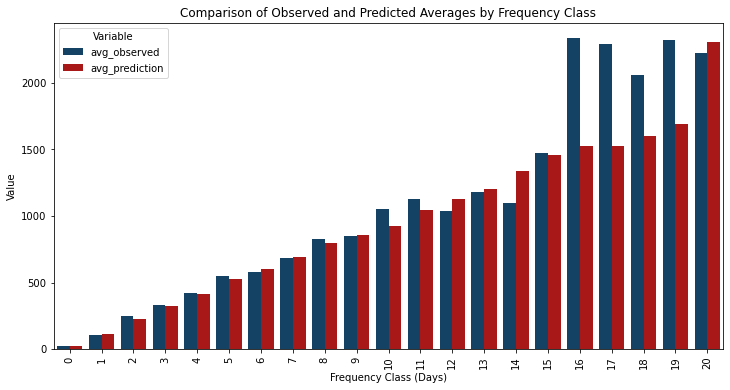

In [17]:
df_frequency = inference_data[inference_data['purchase_frequency_1_yr'] <= 20].copy()

df_frequency_grouped = df_frequency.groupby('purchase_frequency_1_yr').\
    agg(avg_observed = ('purchase_amount_next_1_yr','mean'),
        avg_prediction = ('prediction', 'mean')).\
        reset_index().\
        melt(id_vars='purchase_frequency_1_yr')

# Create a seaborn bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_frequency_grouped, x='purchase_frequency_1_yr', y='value', hue='variable', palette=[PALLETTE['blue'], PALLETTE['red']])

# Add labels and title
plt.xlabel('Frequency Class (Days)')
plt.xticks(rotation=90)
plt.ylabel('Value')
plt.title('Comparison of Observed and Predicted Averages by Frequency Class')
plt.legend(title='Variable')

# Show the plot
plt.show()


### 5.3. Validate predictions by purchase amount class

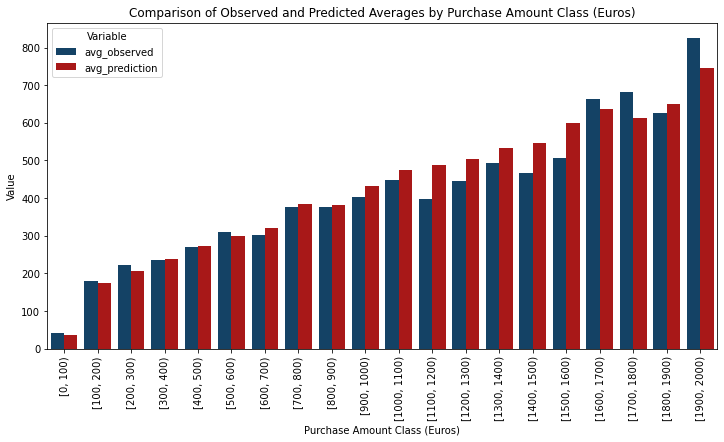

In [18]:
df_purchase_amount = inference_data[inference_data['purchase_amount_1_yr'] <= 2000].copy()

df_purchase_amount['purchase_amount_class'] = pd.cut(df_purchase_amount['purchase_amount_1_yr'], bins=range(0, df_purchase_amount['purchase_amount_1_yr'].astype('int').max() + 100, 100), right=False)

df_purchase_amount_grouped = df_purchase_amount.groupby('purchase_amount_class').\
    agg(avg_observed = ('purchase_amount_next_1_yr','mean'),
        avg_prediction = ('prediction', 'mean')).\
        reset_index().\
        melt(id_vars='purchase_amount_class')

# Create a seaborn bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_purchase_amount_grouped, x='purchase_amount_class', y='value', hue='variable', palette=[PALLETTE['blue'], PALLETTE['red']])

# Add labels and title
plt.xlabel('Purchase Amount Class (Euros)')
plt.xticks(rotation=90)
plt.ylabel('Value')
plt.title('Comparison of Observed and Predicted Averages by Purchase Amount Class (Euros)')
plt.legend(title='Variable')

# Show the plot
plt.show()

### 5.4. Validate predictions by tenure class

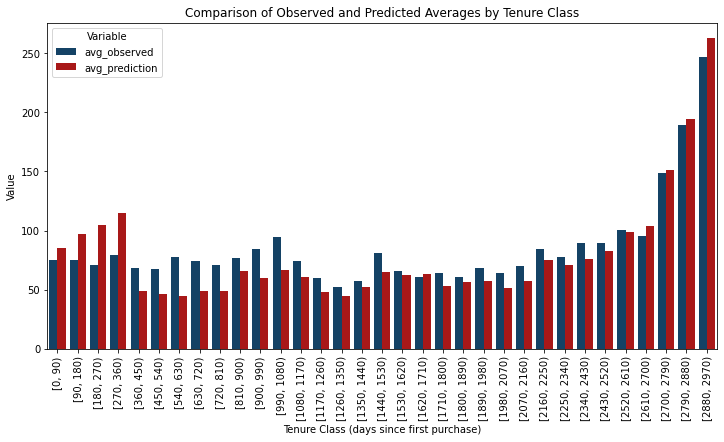

In [19]:
df_tenure = inference_data.copy()

df_tenure['tenure_class'] = pd.cut(df_tenure['tenure'], bins=range(0, df_tenure['tenure'].max() + 90, 90), right=False)

df_tenure_grouped = df_tenure.groupby('tenure_class').\
    agg(avg_observed = ('purchase_amount_next_1_yr','mean'),
        avg_prediction = ('prediction', 'mean')).\
        reset_index().\
        melt(id_vars='tenure_class')

# Create a seaborn bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_tenure_grouped, x='tenure_class', y='value', hue='variable', palette=[PALLETTE['blue'], PALLETTE['red']])

# Add labels and title
plt.xlabel('Tenure Class (days since first purchase)')
plt.xticks(rotation=90)
plt.ylabel('Value')
plt.title('Comparison of Observed and Predicted Averages by Tenure Class')
plt.legend(title='Variable')

# Show the plot
plt.show()

### 5.5. Validate predictions by total purchase amount class

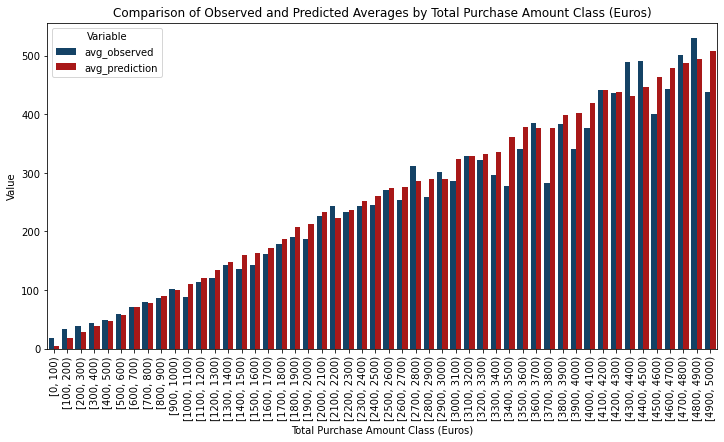

In [20]:
df_total_purchase_amount = inference_data[inference_data['total_purchase_amount'] <= 5000].copy()

df_total_purchase_amount['total_purchase_amount_class'] = pd.cut(df_total_purchase_amount['total_purchase_amount'], bins=range(0, df_total_purchase_amount['total_purchase_amount'].astype('int').max() + 100, 100), right=False)

df_total_purchase_amount_grouped = df_total_purchase_amount.groupby('total_purchase_amount_class').\
    agg(avg_observed = ('purchase_amount_next_1_yr','mean'),
        avg_prediction = ('prediction', 'mean')).\
        reset_index().\
        melt(id_vars='total_purchase_amount_class')

# Create a seaborn bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_total_purchase_amount_grouped, x='total_purchase_amount_class', y='value', hue='variable', palette=[PALLETTE['blue'], PALLETTE['red']])

# Add labels and title
plt.xlabel('Total Purchase Amount Class (Euros)')
plt.xticks(rotation=90)
plt.ylabel('Value')
plt.title('Comparison of Observed and Predicted Averages by Total Purchase Amount Class (Euros)')
plt.legend(title='Variable')

# Show the plot
plt.show()

### 5.6. Validate predictions by returns frequency amount class

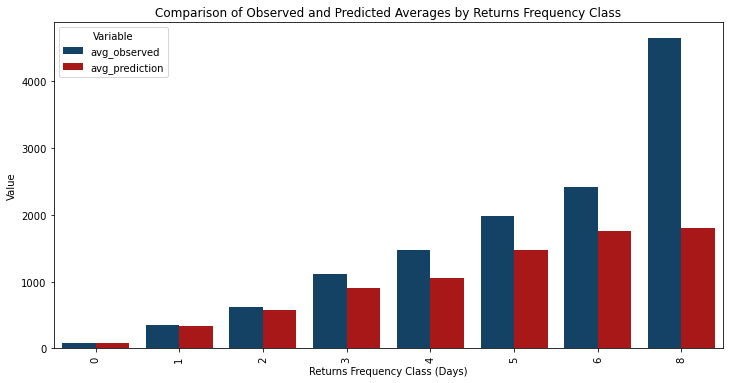

In [21]:
df_returns_frequency = inference_data[inference_data['returns_frequency_1_yr'] <= 20].copy()

df_returns_frequency_grouped = df_returns_frequency.groupby('returns_frequency_1_yr').\
    agg(avg_observed = ('purchase_amount_next_1_yr','mean'),
        avg_prediction = ('prediction', 'mean')).\
        reset_index().\
        melt(id_vars='returns_frequency_1_yr')

# Create a seaborn bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_returns_frequency_grouped, x='returns_frequency_1_yr', y='value', hue='variable', palette=[PALLETTE['blue'], PALLETTE['red']])

# Add labels and title
plt.xlabel('Returns Frequency Class (Days)')
plt.xticks(rotation=90)
plt.ylabel('Value')
plt.title('Comparison of Observed and Predicted Averages by Returns Frequency Class')
plt.legend(title='Variable')

# Show the plot
plt.show()

### 5.7. Validate predictions by returned amount class

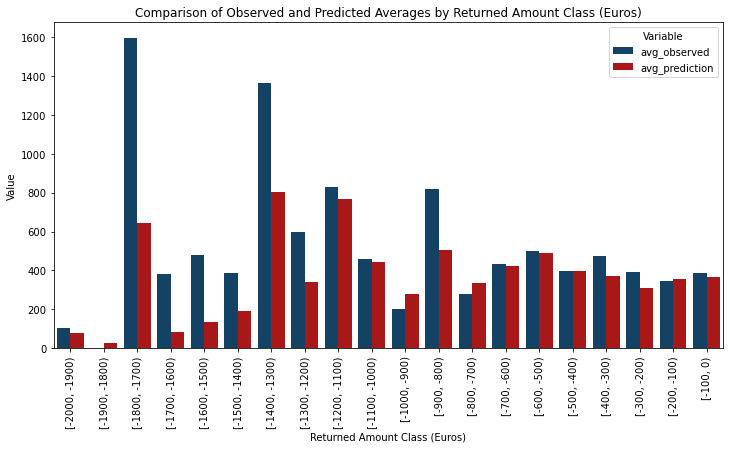

In [22]:
df_returned_amount = inference_data[inference_data['returned_amount_1_yr'] >= -2000].copy()

df_returned_amount['returned_amount_class'] = pd.cut(df_returned_amount['returned_amount_1_yr'], bins=range(-2000, df_returned_amount['returned_amount_1_yr'].astype('int').max() + 100, 100), right=False)

df_returned_amount_grouped = df_returned_amount.groupby('returned_amount_class').\
    agg(avg_observed = ('purchase_amount_next_1_yr','mean'),
        avg_prediction = ('prediction', 'mean')).\
        reset_index().\
        melt(id_vars='returned_amount_class')

# Create a seaborn bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_returned_amount_grouped, x='returned_amount_class', y='value', hue='variable', palette=[PALLETTE['blue'], PALLETTE['red']])

# Add labels and title
plt.xlabel('Returned Amount Class (Euros)')
plt.xticks(rotation=90)
plt.ylabel('Value')
plt.title('Comparison of Observed and Predicted Averages by Returned Amount Class (Euros)')
plt.legend(title='Variable')

# Show the plot
plt.show()